In [ ]:
!pip install sagemaker --upgrade -q

In [41]:
# SageMaker setup
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket='dc-ds-ali-playground')
bucket = sess.default_bucket()

In [40]:
# imports
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms

This is a custom Dataset object images should be placed in seprate folder based on train val test in eacch folder should be a file called label.csv that has two column: 1-image path 2-image label

In [34]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file_name='label.csv', transform=None, target_transform=None):
        self.img_labels = pd.read_csv(os.path.join(img_dir, annotations_file_name))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# make lable.csv file
class_map = {'cat':0,
             'dog':1}

label_df = pd.DataFrame({'path': os.listdir('./train')})
label_df['label'] = label_df['path'].map(lambda x: class_map[x.split('.')[0]])
label_df

In [25]:
train_idx = np.random.randint(0, len(label_df), int(0.8 * len(label_df)))
train_idx.shape

# x is your dataset
idx = np.array(range(len(label_df)))
np.random.shuffle(idx)
train_idx, val_idx = idx[:int(0.8*len(label_df))], idx[int(0.8*len(label_df)):]
print(train_idx.shape, val_idx.shape)

(20000,) (5000,)


In [27]:
# Train Validation Split
train_df = label_df.iloc[train_idx,:]
val_df = label_df.iloc[val_idx,:]
train_df.to_csv('train/label.csv', index=False)
val_df.to_csv('val/label.csv', index=False)

In [29]:
# this method is too slow for moving should be changed for large file worked fine for 5000 image
# move val image to val
for img in val_df.path:
    !mv train/{img} val/{img}

In [150]:
# make dataset objects and transformations
# Data augmentation and normalization for training
# Just normalization for validation

from torchvision import transforms

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


train_data = CustomImageDataset('./train', annotations_file_name='label.csv', transform=data_transforms['train'], target_transform=None)
val_data = CustomImageDataset('./val', annotations_file_name='label.csv', transform=data_transforms['val'], target_transform=None)

In [151]:
# make dataloader objects
from torch.utils.data import DataLoader

batch_size = 4

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let us show some of the training images, for fun.



In [99]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images[0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


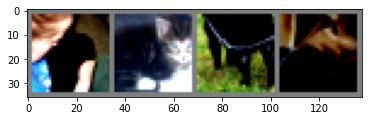

  cat   cat   dog   cat


In [100]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes =   {0:'cat',
             1:'dog'}

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].item()] for j in range(batch_size)))

In [112]:
"""# Define a CNN

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 12)
        self.fc3 = nn.Linear(12, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


net = Net()
print(net)"""

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=12, bias=True)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
)


In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out
    
net = Net().to(device)
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (re

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [156]:
import torch.optim as optim

# should be changed for multiclass to cross entropy

criterion = nn.BCELoss()
optimizer = optim.Adam(params = net.parameters(), lr=0.001)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [158]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float().unsqueeze(1))
        #print(outputs)
        #print(labels.float().unsqueeze(1))
        #print(loss)
        #break
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.699
[1,   200] loss: 0.694
[1,   300] loss: 0.685
[1,   400] loss: 0.687
[1,   500] loss: 0.682
[1,   600] loss: 0.693
[1,   700] loss: 0.683
[1,   800] loss: 0.682
[1,   900] loss: 0.688
[1,  1000] loss: 0.678
[1,  1100] loss: 0.681
[1,  1200] loss: 0.678
[1,  1300] loss: 0.688
[1,  1400] loss: 0.692
[1,  1500] loss: 0.681
[1,  1600] loss: 0.698
[1,  1700] loss: 0.674
[1,  1800] loss: 0.672
[1,  1900] loss: 0.667
[1,  2000] loss: 0.683
[1,  2100] loss: 0.676
[1,  2200] loss: 0.670
[1,  2300] loss: 0.662
[1,  2400] loss: 0.658
[1,  2500] loss: 0.676
[1,  2600] loss: 0.667
[1,  2700] loss: 0.651
[1,  2800] loss: 0.665
[1,  2900] loss: 0.679
[1,  3000] loss: 0.682
[1,  3100] loss: 0.671
[1,  3200] loss: 0.658
[1,  3300] loss: 0.647
[1,  3400] loss: 0.662
[1,  3500] loss: 0.672
[1,  3600] loss: 0.640
[1,  3700] loss: 0.652
[1,  3800] loss: 0.653
[1,  3900] loss: 0.652
[1,  4000] loss: 0.660
[1,  4100] loss: 0.648
[1,  4200] loss: 0.655
[1,  4300] loss: 0.626
[1,  4400] 

In [159]:
PATH = './cat_dog_net.pth'
torch.save(net.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


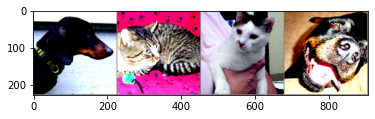

GroundTruth:    dog   cat   cat   dog


In [160]:
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

In [161]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [162]:
outputs = net(images)

In [163]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(4)))

Predicted:    cat   cat   cat   cat


In [164]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = outputs > 0.5
        predicted = predicted.type(torch.LongTensor)
        predicted = predicted.reshape(1, -1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(correct, total)
print('Accuracy of the network on the 5000 val images: %d %%' % (100 * correct / total))

3268 5000
Accuracy of the network on the 5000 val images: 65 %


In [165]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in [0, 1]}
total_pred = {classname: 0 for classname in [0, 1]}

# again no gradients needed
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data    
        outputs = net(images)    
        predictions = outputs > 0.5
        predictions = predictions.type(torch.LongTensor)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(classname,  accuracy)

0 63.140896245458215
1 67.61791518034086
